In [1]:
import pIRPgym

# Stochastic-Dynamic Inventory-Routing-Problem with Perishable Products Environment

by: Juan Betancourt

<div style="text-align: justify"> 
This Jupyter Notebook is dedicated to offering an in-depth, step-by-step guide to create and employ an environment for the SD-IB-IRP-PP. The document's content can be summarized as follows:
</div> 

1. Powelleskian Model

2. Instance Generator

3. Environment

4. Policies

5. Step Iteration

6. Episode Simulation

## 1. Powelleskian Model

### State ($S_t$)
-   **Physical State** ($R_t$):

        state:  Current available inventory: (dict)  Inventory of product k \in K of age o \in O_k. Since the state is the inventory before the decision is taken, there is no age 0 inventory.
                
        When backlogs are activated, will appear under age 'B'   
                                           

-   **Other deterministic info** ($Z_t$):

        p: Prices: (dict) Price of product k \in K at supplier i \in M
    
        q: Available quantities: (dict) Available quantity of product k \in K at supplier i \in M
    
        h: Holding cost: (dict) Holding cost of product k \in K
    
        historical_data: (dict) Historical log of information (optional)
    
-   **Belief State** ($B_t$):
    
        sample_paths: Simulated sample paths (optional)


### Actions ($X_t$)
The action can be seen as a three level-decision. These are the three layers:

1. Routes to visit the selected suppliers

2. Quantities to purchase from each supplier

3. Demand compliance plan, dispatch decision

4. (Optional) Backlogs compliance

Accordingly, the action will be a list composed as follows:

$$ X = [\text{routes, purchase, demand compliance, backlogs compliance}] $$

        routes: (list) list of lists, each with the nodes visited on the route (including departure and arriving to the depot)

        purchase: (dict) Units to purchase of product k \in K at supplier i \in M

        demand_compliance: (dict) Units of product k in K of age o \in O_k used to satisfy the demand

        backlogs_compliance: (dict) Units of product k in K of age o \in O_k used to satisfy the backlogs

### Exogenous information ($W_t$)


### Transition Function ($S_M^X$)

### Cost Function ($C_t$)

## 2. Instance generator

<div style="text-align: justify"> 
Prior to generating an environment, an instance generator object must be created. This instance generator will contain all of the parameters, deterministic and stochastic, of the problem. This object receives two types of parameters: structural and instantial. 
</div> 

### Instantial parameters

- Time Horizon: Number of decision periods (time steps) per simulation
    
        T = 7

- Suppliers: Number of suppliers

        M = 10

- Products: Number of products

        K = 5

- Fleet: Number of vehicles

        F = 4

- Capacity: Vehicles' capacity

        Q = 40

- Maximum distance per route

        d_max = 500

In [2]:
T = 8
M = 15
K = 15
F = 15

Q = 750
d_max = 2500

### Structural parameters

These parameters define the type of instance that will be generated and the configuration to each one of the possibilites. 

- Look-ahead approximation: Generation of sample paths (<kbd>look_ahead = ['d','q']</kbd>):

    1. List of parameters to be forecasted on the look-ahead approximation ['d', 'p', ...]

    2. List with '*' to generate forecasts for all parameters

    3. False for no sample path generation

    Related parameters:

        - S: Number of sample paths
        
        - LA_horizon: Number of look-ahead periods, includes the current decision period.

In [3]:
look_ahead = ['d','q']

S = 8
LA_horizon = 4

- Stocastic parameters: Considering stochastic parameters, meaning the forecast for today are not the same realized values (<kbd>stochastic_params = ['d','q']</kbd>):

    1. List with parameters to be stochastic ['d', 'p', ...]

    2. List with '*' to consider all parameters as stochastic

    3. False for deterministic parameters

In [4]:
stochastic_params = ['d','q']

- Historical data: Generation or usage of historical data (<kbd>historical_data = ['*']</kbd>)   

    1. List with the parameters the historical info will be generated for ['d', 'p', ...]

    2.  List with '*' to generate historical for all parameters

    3.  False to don't generate historical data. However, a historical log will be generated for realized observations during the episode

    Related parameter:
        
        - hist_window: Initial log size (time periods)

In [5]:
historical_data = ['*']

hist_window = 10

-  Backorders: Catch unsatisfied demand (<kbd>backorders = False</kbd>):

    1. 'backorders': Demand may be not fully satisfied. Non-complied orders will be automatically fullfilled with an extra-cost

    2. 'backlogs': Demand may be not fully satisfied. Non-complied orders will be registered and kept track of on age 'B'

    3. False: All demand must be fullfilled

    Related parameters:

        - back_o_cost = 600
        - back_l_cost = 600

In [6]:
backorders =  'backorders'
back_o_cost = 600

Having defined all these parameters, they are packed on a dictionary and the instance generator object is created.

In [7]:
env_config = {  'M': M,                         # Structural parameters
                'K': K, 
                'T': T, 
                'F': F, 
                
                'Q': Q,
                'd_max': d_max,

                'S': S,                         # Look-ahead
                'LA_horizon': LA_horizon, 
                
                'hist_window': hist_window      # Historical data
            }

inst_gen = pIRPgym.instance_generator(look_ahead, stochastic_params, historical_data, backorders, env_config = env_config)

<div style="text-align: justify"> 
Depending on the interest of the user, various types of instances can be generated. For this demonstration a basic random instance is generated. The distributions and parameters for each of the instance's parameters are defined, the random seed is set and the instance is generated.
</div> 

In [8]:
q_params = {'dist': 'c_uniform', 'r_f_params': [6,20]}          # Offer
p_params = {'dist': 'd_uniform', 'r_f_params': [20,61]}

d_params = {'dist': 'log-normal', 'r_f_params': [2,0.5]}        # Demand

h_params = {'dist': 'd_uniform', 'r_f_params': [20,61]}         # Holding costs

disc = ("strong","conc")

stoch_rd_seed = 0                                               # Random seeds
det_rd_seed = 1

inst_gen.generate_basic_random_instance(det_rd_seed,stoch_rd_seed,q_params = q_params,
                                        p_params = p_params,d_params = d_params,
                                        h_params = h_params,discount = disc)

<div style="text-align: justify"> 
Once the instance is generated, all parameters can be accessed through the object. Some parameters are presented below:

- Historic values: <kbd>hist_</kbd> and the letter of the parameter (<kbd>hist_d</kbd>,<kbd> hist_q</kbd>, <kbd>hist_</kbd>...)

        hist_q[t][i,k] /forall i in Suppliers for k in Products
        hist_p[t][i,k] /forall i in Suppliers for k in Products
        hist_d[t][k] /forall k in Products
        hist_h[t][k] /forall k in Products

- Realized parameters: <kbd>W_</kbd> and the letter of the parameter (<kbd>W_d</kbd>, <kbd>W_q</kbd>, <kbd>W_</kbd>...)
        
        W_q[t][i,k] /forall i in Suppliers for k in Products
        W_p[t][i,k] /forall i in Suppliers for k in Products
        W_d[t][k] /forall k in Products
        W_h[t][k] /forall k in Products

- Sample paths: <kbd>s_paths_</kbd> and the letter of the parameter (<kbd>s_paths_d</kbd>, <kbd>s_paths_q</kbd>, <kbd>s_paths_</kbd>...). An important consideration to have is that the day index always starts in 0. Meaning the sample paths of day 0 are 
the samples of the current period t.

        s_paths_q[t][day,sample][i,k] /forall i in Suppliers for k in Products; /forall day for sample in Samples
        s_paths_p[t][day,sample][i,k] /forall i in Suppliers for k in Products; /forall day for sample in Samples
        s_paths_d[t][day,sample][k] /forall k in Products; /forall day for sample in Samples
        s_paths_h[t][day,sample][k] /forall k in Products; /forall day for sample in Samples  
        



</div> 

In [9]:
t = 0   # First day
i = 1   # First supplier
k = 0   # First product

print(f'The historic available quantities are {[round(i,2) for i in inst_gen.hist_q[t][i,k]]}')
print(f'The realized available qunatities are {inst_gen.W_q[t][i,k]}')

s = 0   # First sample
day = 0 # First day of the sample paths (current period t)
print(f'The forecasted available quantities are {inst_gen.s_paths_q[t][day,s][i,k]}')

The historic available quantities are [14.44, 17.33, 27.44, 11.55, 0, 21.66, 21.66, 0, 0, 23.1]
The realized available qunatities are 11
The forecasted available quantities are 23.103781474871663


# 3. Environment

<div style="text-align: justify"> 
After the instance is generated, the enviroment is created. The object steroid_IRP receives three parameters: 
</div> 

        routing: bool
        inventory: bool
        perishability: str

<div style="text-align: justify"> 
The first two parameters indicate whether the problem will contemplate routing and inventory management components, respectively. The third parameter, only availabe if inventory management is used, indicates the model of perishability. 
</div> 

In [10]:
routing = True
inventory = True
perishability = 'ages'

env = pIRPgym.steroid_IRP(routing,inventory,perishability)

<div style="text-align: justify"> 
To start the environment, it must be reset. The environment's method <kbd>print_state</kbd> receives the <kbd>instance_generator</kbd> object and prints the inventory, the demand and the available quantities. 
</div>

In [11]:
state = env.reset(inst_gen,return_state = True)
env.print_state(inst_gen)

################################### STEP 0 ###################################
INVENTORY
K \ O 	 1 	2 	3 	4 	5 	6 	7 	8 	
k0 	 0 	0 	0 	0 	0 	0 	
k1 	 0 	0 	0 	0 	0 	0 	0 	0 	
k2 	 0 	0 	0 	0 	0 	0 	
k3 	 0 	0 	0 	0 	
k4 	 0 	0 	0 	0 	
k5 	 0 	0 	0 	0 	0 	0 	0 	
k6 	 0 	0 	0 	0 	0 	0 	0 	0 	
k7 	 0 	0 	0 	0 	
k8 	 0 	0 	0 	0 	0 	
k9 	 0 	0 	0 	0 	0 	0 	0 	
k10 	 0 	0 	0 	0 	0 	0 	0 	
k11 	 0 	0 	0 	0 	
k12 	 0 	0 	0 	0 	0 	
k13 	 0 	0 	0 	
k14 	 0 	0 	0 	0 	0 	


DEMAND
K	0	1	2	3	4	5	6	7	8	9	10	11	12	13	14
d	17.85	9.03	12.05	22.66	18.8	4.53	11.88	6.85	7.02	9.07	7.94	15.29	10.81	7.85	9.23


AVAILABLE QUANTITIES
M\K 	0 	1 	2 	3 	4 	5 	6 	7 	8 	9 	10 	11 	12 	13 	14 	
1	11	17	0	18	0	0	14	15	17	11	6	0	6	0	7	
2	18	13	19	18	0	0	0	0	0	12	15	8	0	10	11	
3	0	8	0	0	0	0	10	0	0	17	0	18	0	16	18	
4	19	8	0	0	0	0	10	0	0	13	0	13	15	0	0	
5	0	7	0	0	13	0	6	12	0	0	19	0	15	15	13	
6	19	0	12	15	7	0	0	6	0	0	18	0	7	14	14	
7	0	19	0	0	0	9	0	16	15	14	13	0	9	0	12	
8	11	7	0	0	0	15	0	0	0	9	0	10	14	0	0	
9	0	7	0	0	0	0	1

# 4. Policies

<div style="text-align: justify"> 
Finally, the class policy_generator has three main sub-classes: Purchasing, Inventory and Routing. Each one of these contains methods with different strategies for the different decisions that must be made. For example, the class Purchasing has the method <kbd>det_purchase_all</kbd> that buys all available quantities (considering deterministic information), the class Inventory has the method <kbd>det_FIFO</kbd> that complies the demand with older product (considering deterministic information), and the class Routing has the method <kbd>NearestNeighbor</kbd> that uses a nearest neighbor heuristic to route the suppliers. Each one of the policies receives different parameters but most of them take the <kbd>instance_generator</kbd>, the <kbd>state</kbd> and the <kbd>environment</kbd>.
</div> 

In [12]:
purchase = pIRPgym.Purchasing.det_purchase_all(inst_gen, env)
demand_compliance = pIRPgym.Inventory.det_FIFO(purchase,inst_gen,env)
routing,cost,_,_ = pIRPgym.Routing.NearestNeighbor(purchase,inst_gen,t)

# 5. Step iteration

<div style="text-align: justify"> 
With all of these components, the environment can be used as a simulation tool. The action generated is given to the envoriment through the <kbd>step</kbd> method. This method receives the action as a list and the instance generator object. It returns the <kbd>state</kbd>, the <kbd>reward</kbd>, a boolean <kbd>done</kbd> indicating the episode has finalized, the <kbd>real_action</kbd> (if <kbd>stochastic_parameters</kbd> is activated) and some additional information.
</div> 

In [13]:
action = {'routing':routing,'purchase':purchase,'demand_compliance':demand_compliance}
state, reward, done, real_action, _ = env.step(action, inst_gen)
env.print_state(inst_gen)

################################### STEP 1 ###################################
INVENTORY
K \ O 	 1 	2 	3 	4 	5 	6 	7 	8 	
k0 	 114.15 	0 	0 	0 	0 	0 	
k1 	 119.97 	0 	0 	0 	0 	0 	0 	0 	
k2 	 31.95 	0 	0 	0 	0 	0 	
k3 	 53.34 	0 	0 	0 	
k4 	 28.2 	0 	0 	0 	
k5 	 33.47 	0 	0 	0 	0 	0 	0 	
k6 	 108.12 	0 	0 	0 	0 	0 	0 	0 	
k7 	 90.15 	0 	0 	0 	
k8 	 83.98 	0 	0 	0 	0 	
k9 	 125.93 	0 	0 	0 	0 	0 	0 	
k10 	 119.06 	0 	0 	0 	0 	0 	0 	
k11 	 85.71 	0 	0 	0 	
k12 	 108.19 	0 	0 	0 	0 	
k13 	 123.15 	0 	0 	
k14 	 121.77 	0 	0 	0 	0 	


DEMAND
K	0	1	2	3	4	5	6	7	8	9	10	11	12	13	14
d	8.73	15.6	6.67	8.64	4.82	2.06	10.25	11.38	5.1	22.99	3.57	7.56	6.73	15.9	15.4


AVAILABLE QUANTITIES
M\K 	0 	1 	2 	3 	4 	5 	6 	7 	8 	9 	10 	11 	12 	13 	14 	
1	0	8	18	0	0	0	0	17	0	0	11	17	0	0	13	
2	0	0	19	14	17	18	17	10	10	0	13	0	0	0	0	
3	13	0	19	0	10	15	6	18	8	0	6	0	19	16	0	
4	0	0	0	0	13	18	0	0	7	0	13	15	14	0	16	
5	0	0	18	0	0	0	0	0	10	0	6	0	18	0	0	
6	0	7	18	0	15	14	0	8	9	7	8	0	18	0	18	
7	0	13	0	8	16	12	6	0	15	8	12	0	

# 6. Complete iteration

<div style="text-align: justify"> 
In this way, a complete episode can be simulated using all the components described before. In this case, we evaluate the performance of a set of routing policies. As key performance metrics, the total cost, the lost sales (units) and the perished product (units) is saved throught the episode.
</div> 

In [14]:
total_cost = 0
lost_sales = 0
perished_product = 0

res = {'CG':{'Obj':[]},'NN':{'Obj':[]},'RCL':{'Obj':[]},'GA':{'Obj':[]}}

env.reset(inst_gen)
done = False

while not done:
    print(f'time step {env.t}')
    ''' Purchasing and Inventory policies'''
    purchase = pIRPgym.Purchasing.det_purchase_all(inst_gen, env)
    demand_compliance = pIRPgym.Inventory.det_FIFO(purchase,inst_gen,env)

    ''' Routing policies'''
    CG_routes,CG_obj,CG_info,CG_time = pIRPgym.Routing.ColumnGeneration(purchase,inst_gen,env.t,time_limit=20,verbose=False)

    nn_routes,nn_obj,nn_info,nn_time = pIRPgym.Routing.NearestNeighbor(purchase,inst_gen,env.t)

    RCL_obj,RCL_veh,RCL_time,RCL_stats = pIRPgym.Routing.evaluate_stochastic_policy(pIRPgym.Routing.RCL_Heuristic,
                                                                                           purchase,inst_gen,env,n=10,
                                                                                           return_average=True,dynamic_p=False,
                                                                                           RCL_alphas=[0.2],adaptative=True,
                                                                                           time_limit=2)

    GA_routes,GA_obj,(GA_distances,GA_loads),GA_time,_ = pIRPgym.Routing.GenticAlgorithm(purchase,inst_gen,env.t,
                                                                                               return_top=False,rd_seed=env.t,
                                                                                               time_limit=15)    # Genetic Algorithm

    res['CG']['Obj'].append(CG_obj)
    res['NN']['Obj'].append(nn_obj)
    res['RCL']['Obj'].append(RCL_obj)
    res['GA']['Obj'].append(GA_obj)

    action = {'routing':CG_routes,'purchase':purchase,'demand_compliance':demand_compliance}
    
    state,reward,done,real_action, _ = env.step(action, inst_gen)

    total_cost += sum(reward.values())
    lost_sales += sum(_['backorders'].values())
    perished_product += sum(_['perished'].values())

print(f'Simulation finished')
print('-------------------------')
print(f'Total cost: ${total_cost}')
print(f'Lost sales: {lost_sales}')
print(f'Perished units: {perished_product}')

time step 0
Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-11


time step 1
time step 2
time step 3
time step 4
time step 5
time step 6
time step 7
Simulation finished
-------------------------
Total cost: $3152408.2308480847
Lost sales: 0
Perished units: 2814.24


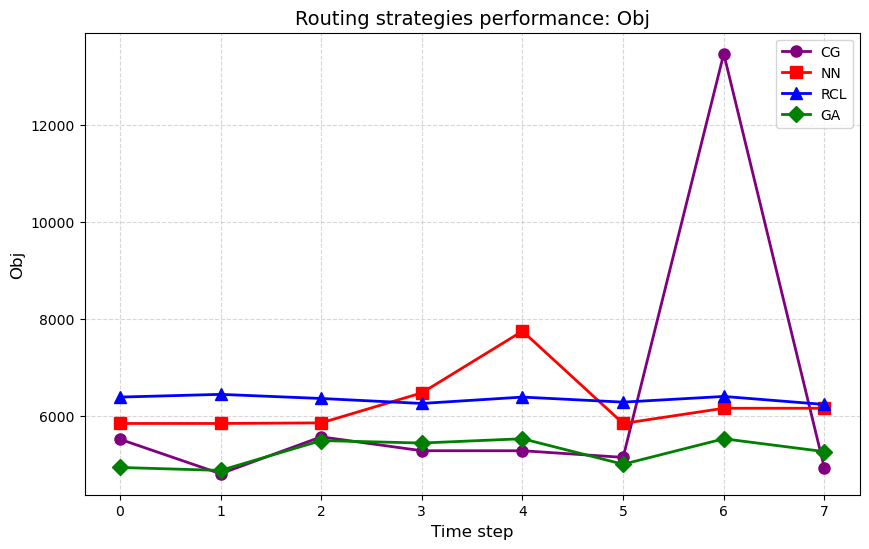

In [15]:
pIRPgym.Visualizations.RoutingV.plot_indicator_evolution(res,'Obj')